<a href="https://colab.research.google.com/github/mateusz-kacpura/exercises-python/blob/main/Apriori%20i%20PCY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Przygotowanie danych:

In [3]:
import random
import csv

def generate_dataset(num_transactions, num_items, max_items_per_transaction, filename='DATASET.csv'):
    """
    Generuje zbiór danych i zapisuje go do pliku CSV.

    :param num_transactions: Liczba transakcji
    :param num_items: Liczba unikalnych przedmiotów
    :param max_items_per_transaction: Maksymalna liczba przedmiotów w jednej transakcji
    :param filename: Nazwa pliku do zapisu
    """
    items = [f'item_{i}' for i in range(1, num_items + 1)]
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for _ in range(num_transactions):
            transaction_size = random.randint(1, max_items_per_transaction)
            transaction = random.sample(items, transaction_size)
            writer.writerow(transaction)

# Przykładowe użycie:
generate_dataset(num_transactions=10000, num_items=100, max_items_per_transaction=10)


# 2. Funkcja wczytująca dane z pliku

In [4]:
def read_dataset(fname):
    """
    Wczytuje zbiór danych z pliku CSV.

    :param fname: Ścieżka do pliku CSV
    :return: Lista transakcji, gdzie każda transakcja jest listą przedmiotów
    """
    data = []
    with open(fname, 'r') as file_iter:
        for line in file_iter:
            transaction = line.strip().strip(',').split(',')
            data.append(transaction)
    return data

# Przykładowe użycie:
data = read_dataset('DATASET.csv')


# 3. Implementacja algorytmu apriori

In [5]:
def apriori(data, k, support):
    """
    Implementacja algorytmu Apriori.

    :param data: Lista transakcji
    :param k: Maksymalny rozmiar zbiorów
    :param support: Minimalne wsparcie
    :return: Lista częstych zbiorów elementów
    """
    # Zliczanie wystąpień pojedynczych elementów
    count_single = {}
    for transaction in data:
        for item in transaction:
            count_single[item] = count_single.get(item, 0) + 1

    # Wybieranie częstych elementów
    frequent_items = [[] for _ in range(k)]
    frequent_items[0] = [set([item]) for item, count in count_single.items() if count >= support]

    # Generowanie zbiorów dla większych rozmiarów
    for i in range(1, k):
        candidates = []
        len_prev = len(frequent_items[i-1])
        for m in range(len_prev):
            for n in range(m+1, len_prev):
                union = frequent_items[i-1][m].union(frequent_items[i-1][n])
                if len(union) == i + 1:
                    # Sprawdzenie, czy podzbiory są częste
                    subsets = [union - set([item]) for item in union]
                    if all(subset in frequent_items[i-1] for subset in subsets):
                        candidates.append(union)

        # Zliczanie wsparcia kandydatów
        count_candidates = [0] * len(candidates)
        for transaction in data:
            transaction_set = set(transaction)
            for idx, candidate in enumerate(candidates):
                if candidate.issubset(transaction_set):
                    count_candidates[idx] += 1

        # Wybieranie częstych zbiorów
        for idx, count in enumerate(count_candidates):
            if count >= support:
                frequent_items[i].append(candidates[idx])

    # Scalanie wyników
    result = []
    for level in frequent_items:
        result.extend(level)
    return result

# Przykładowe użycie:
k = 3
min_support = 50
result_apriori = apriori(data, k, min_support)
print(f"Częste zbiory elementów (Apriori): {result_apriori}")

Częste zbiory elementów (Apriori): [{'item_92'}, {'item_14'}, {'item_81'}, {'item_10'}, {'item_5'}, {'item_8'}, {'item_64'}, {'item_36'}, {'item_24'}, {'item_86'}, {'item_56'}, {'item_32'}, {'item_93'}, {'item_21'}, {'item_47'}, {'item_59'}, {'item_38'}, {'item_85'}, {'item_13'}, {'item_80'}, {'item_70'}, {'item_53'}, {'item_77'}, {'item_87'}, {'item_75'}, {'item_4'}, {'item_39'}, {'item_89'}, {'item_19'}, {'item_76'}, {'item_51'}, {'item_71'}, {'item_6'}, {'item_42'}, {'item_49'}, {'item_26'}, {'item_58'}, {'item_11'}, {'item_82'}, {'item_100'}, {'item_2'}, {'item_27'}, {'item_83'}, {'item_60'}, {'item_63'}, {'item_72'}, {'item_98'}, {'item_31'}, {'item_22'}, {'item_52'}, {'item_44'}, {'item_23'}, {'item_62'}, {'item_91'}, {'item_33'}, {'item_3'}, {'item_17'}, {'item_40'}, {'item_29'}, {'item_67'}, {'item_88'}, {'item_73'}, {'item_25'}, {'item_65'}, {'item_68'}, {'item_69'}, {'item_94'}, {'item_99'}, {'item_46'}, {'item_97'}, {'item_18'}, {'item_54'}, {'item_74'}, {'item_61'}, {'item_

# 4. Implementacja algorytmu PCY

In [6]:
def hash_pair(item1, item2, hash_buckets):
    """
    Funkcja haszująca parę elementów do odpowiedniego koszyka.

    :param item1: Pierwszy element
    :param item2: Drugi element
    :param hash_buckets: Liczba koszyków haszujących
    :return: Indeks koszyka
    """
    return hash(frozenset([item1, item2])) % hash_buckets

def pcy(transactions, min_support, hash_buckets, k=2):
    """
    Implementacja algorytmu PCY.

    :param transactions: Lista transakcji
    :param min_support: Minimalne wsparcie
    :param hash_buckets: Liczba koszyków haszujących
    :param k: Maksymalny rozmiar zbiorów (domyślnie 2 dla par)
    :return: Zbiór częstych zbiorów elementów
    """
    # Pierwsza iteracja: Zliczanie wsparcia dla pojedynczych elementów
    single_count = {}
    hash_table = [0] * hash_buckets
    for transaction in transactions:
        for item in transaction:
            single_count[item] = single_count.get(item, 0) + 1
        # Hashowanie wszystkich par w transakcji
        for i in range(len(transaction)):
            for j in range(i+1, len(transaction)):
                pair_hash = hash_pair(transaction[i], transaction[j], hash_buckets)
                hash_table[pair_hash] += 1

    # Tworzenie bitmapy na podstawie progu wsparcia
    bitmap = [0] * hash_buckets
    for idx, count in enumerate(hash_table):
        if count >= min_support:
            bitmap[idx] = 1

    # Wybór częstych elementów
    frequent_items = set([item for item, count in single_count.items() if count >= min_support])

    # Generowanie kandydatów na częste pary
    candidate_pairs = set()
    for transaction in transactions:
        transaction_frequent = [item for item in transaction if item in frequent_items]
        for i in range(len(transaction_frequent)):
            for j in range(i+1, len(transaction_frequent)):
                item1, item2 = transaction_frequent[i], transaction_frequent[j]
                pair_hash = hash_pair(item1, item2, hash_buckets)
                if bitmap[pair_hash]:
                    # Używamy sorted tuple dla jednolitu
                    candidate_pairs.add(tuple(sorted([item1, item2])))

    # Zliczanie wsparcia dla kandydatów
    pair_count = {pair:0 for pair in candidate_pairs}
    for transaction in transactions:
        transaction_set = set(transaction)
        for pair in candidate_pairs:
            if set(pair).issubset(transaction_set):
                pair_count[pair] += 1

    # Wybór częstych par
    frequent_pairs = [set(pair) for pair, count in pair_count.items() if count >= min_support]

    # Scalanie wyników
    result = list(frequent_pairs)
    return result

# Przykładowe użycie:
result_pcy = pcy(data, min_support=50, hash_buckets=1000)
print(f"Częste pary elementów (PCY): {result_pcy}")


Częste pary elementów (PCY): [{'item_67', 'item_19'}, {'item_20', 'item_87'}, {'item_95', 'item_72'}, {'item_36', 'item_73'}, {'item_60', 'item_37'}, {'item_4', 'item_19'}, {'item_13', 'item_52'}, {'item_97', 'item_73'}, {'item_11', 'item_83'}, {'item_70', 'item_36'}, {'item_36', 'item_43'}, {'item_73', 'item_9'}, {'item_10', 'item_7'}, {'item_20', 'item_92'}, {'item_27', 'item_85'}, {'item_32', 'item_71'}, {'item_76', 'item_30'}, {'item_36', 'item_85'}, {'item_83', 'item_26'}, {'item_96', 'item_3'}, {'item_10', 'item_8'}]


# 5. Rozszerzenie PCY do większych zbiorów (k > 2)

In [7]:
def pcy_extended(transactions, min_support, hash_buckets, max_k):
    """
    Rozszerzona implementacja algorytmu PCY do znajdowania częstych zbiorów o różnych rozmiarach.

    :param transactions: Lista transakcji
    :param min_support: Minimalne wsparcie
    :param hash_buckets: Liczba koszyków haszujących
    :param max_k: Maksymalny rozmiar zbiorów
    :return: Lista częstych zbiorów elementów
    """
    frequent_itemsets = []
    # Pierwsza iteracja (k=1)
    single_count = {}
    for transaction in transactions:
        for item in transaction:
            single_count[item] = single_count.get(item, 0) + 1

    frequent_single = set([item for item, count in single_count.items() if count >= min_support])
    frequent_itemsets.append([set([item]) for item in frequent_single])

    for k in range(2, max_k + 1):
        candidate = set()
        prev_frequent = frequent_itemsets[k-2]
        len_prev = len(prev_frequent)
        # Generowanie kandydatów przez łączenie zbiorów z poprzedniego kroku
        prev_frequent_list = list(prev_frequent)
        for i in range(len_prev):
            for j in range(i+1, len_prev):
                union = prev_frequent_list[i].union(prev_frequent_list[j])
                if len(union) == k:
                    # Sprawdzenie, czy wszystkie podzbiory są częste
                    subsets = [union - set([item]) for item in union]
                    if all(subset in frequent_itemsets[k-2] for subset in subsets):
                        candidate.add(tuple(sorted(union)))

        # Zliczanie wsparcia kandydatów za pomocą hash table
        hash_table = [0] * hash_buckets
        for transaction in transactions:
            transaction_frequent = [item for item in transaction if item in frequent_single]
            for i in range(len(transaction_frequent)):
                for j in range(i+1, len(transaction_frequent)):
                    pair_hash = hash_pair(transaction_frequent[i], transaction_frequent[j], hash_buckets)
                    hash_table[pair_hash] += 1

        # Tworzenie bitmapy
        bitmap = [0] * hash_buckets
        for idx, count in enumerate(hash_table):
            if count >= min_support:
                bitmap[idx] = 1

        # Generowanie kandydatów na podstawie bitmapy
        candidate_pairs = set()
        for candidate_set in candidate:
            pairs = list(combinations(candidate_set, 2))
            include = True
            for pair in pairs:
                pair_hash = hash_pair(pair[0], pair[1], hash_buckets)
                if not bitmap[pair_hash]:
                    include = False
                    break
            if include:
                candidate_pairs.add(candidate_set)

        # Zliczanie wsparcia dla kandydatów
        count_candidates = {tuple(sorted(candidate_set)):0 for candidate_set in candidate_pairs}
        for transaction in transactions:
            transaction_set = set(transaction)
            for candidate_set in candidate_pairs:
                if set(candidate_set).issubset(transaction_set):
                    count_candidates[tuple(sorted(candidate_set))] += 1

        # Wybieranie częstych zbiorów
        current_frequent = [set(k_set) for k_set, count in count_candidates.items() if count >= min_support]
        if not current_frequent:
            break
        frequent_itemsets.append(current_frequent)

    # Scalanie wyników
    result = []
    for level in frequent_itemsets:
        result.extend(level)
    return result

from itertools import combinations

# Przykładowe użycie:
max_k = 3
result_pcy_ext = pcy_extended(data, min_support=50, hash_buckets=1000, max_k=max_k)
print(f"Częste zbiory elementów (PCY Extended): {result_pcy_ext}")


Częste zbiory elementów (PCY Extended): [{'item_30'}, {'item_39'}, {'item_70'}, {'item_75'}, {'item_41'}, {'item_46'}, {'item_73'}, {'item_100'}, {'item_60'}, {'item_25'}, {'item_92'}, {'item_50'}, {'item_62'}, {'item_99'}, {'item_85'}, {'item_89'}, {'item_42'}, {'item_6'}, {'item_17'}, {'item_21'}, {'item_12'}, {'item_77'}, {'item_69'}, {'item_91'}, {'item_95'}, {'item_93'}, {'item_8'}, {'item_22'}, {'item_20'}, {'item_63'}, {'item_72'}, {'item_19'}, {'item_3'}, {'item_18'}, {'item_48'}, {'item_64'}, {'item_36'}, {'item_29'}, {'item_2'}, {'item_15'}, {'item_84'}, {'item_34'}, {'item_66'}, {'item_7'}, {'item_87'}, {'item_5'}, {'item_11'}, {'item_43'}, {'item_49'}, {'item_24'}, {'item_81'}, {'item_71'}, {'item_98'}, {'item_9'}, {'item_74'}, {'item_44'}, {'item_96'}, {'item_45'}, {'item_16'}, {'item_28'}, {'item_76'}, {'item_38'}, {'item_68'}, {'item_1'}, {'item_79'}, {'item_57'}, {'item_31'}, {'item_33'}, {'item_27'}, {'item_61'}, {'item_52'}, {'item_56'}, {'item_86'}, {'item_65'}, {'it

# 6. Analiza porównawcza z algorytmem Apriori

a. Pomiar czasu wykonania

In [8]:
import time

# Pomiar czasu dla Apriori
start_time = time.time()
result_apriori = apriori(data, k=3, support=50)
end_time = time.time()
time_apriori = end_time - start_time
print(f"Czas wykonania Apriori: {time_apriori:.4f} sekund")

# Pomiar czasu dla PCY
start_time = time.time()
result_pcy = pcy(data, min_support=50, hash_buckets=1000)
end_time = time.time()
time_pcy = end_time - start_time
print(f"Czas wykonania PCY: {time_pcy:.4f} sekund")

# Pomiar czasu dla PCY
start_time = time.time()
result_pcy_extended = pcy_extended(data, min_support=50, hash_buckets=1000, max_k=3)
end_time = time.time()
time_pcy_extended = end_time - start_time
print(f"Czas wykonania extended PCY: {time_pcy_extended:.4f} sekund")


Czas wykonania Apriori: 6.5859 sekund
Czas wykonania PCY: 16.9146 sekund
Czas wykonania extended PCY: 14.9857 sekund


b. Pomiar zużycia pamięci

In [ ]:
import tracemalloc

# Pomiar pamięci dla Apriori
tracemalloc.start()
result_apriori = apriori(data, k=3, support=50)
current, peak_apriori = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Zużycie pamięci Apriori: {peak_apriori / 10**6:.4f} MB")

# Pomiar pamięci dla PCY
tracemalloc.start()
result_pcy = pcy(data, min_support=50, hash_buckets=1000)
current, peak_pcy = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Zużycie pamięci PCY: {peak_pcy / 10**6:.4f} MB")

# Pomiar pamięci dla PCY
tracemalloc.start()
result_pcy_extended = pcy_extended(data, min_support=50, hash_buckets=1000, max_k=3)
current, peak_pcy_extended = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Zużycie pamięci PCY: {peak_pcy_extended / 10**6:.4f} MB")


Zużycie pamięci Apriori: 2.0899 MB
Zużycie pamięci PCY: 0.5611 MB
Zużycie pamięci PCY: 1.3767 MB


c. Przedstawienie wyników

In [ ]:
import pandas as pd

# Dane do tabeli
data_comparison = {
    'Algorytm': ['Apriori', 'PCY Extended'],
    'Czas wykonania (s)': [time_apriori, time_pcy],
    'Zużycie pamięci (MB)': [peak_apriori / 10**6, peak_pcy / 10**6]
}

df_comparison = pd.DataFrame(data_comparison)
print(df_comparison)


       Algorytm  Czas wykonania (s)  Zużycie pamięci (MB)
0       Apriori            5.232836              1.271097
1  PCY Extended           13.634590              1.407799


d. Wykres porównawczy

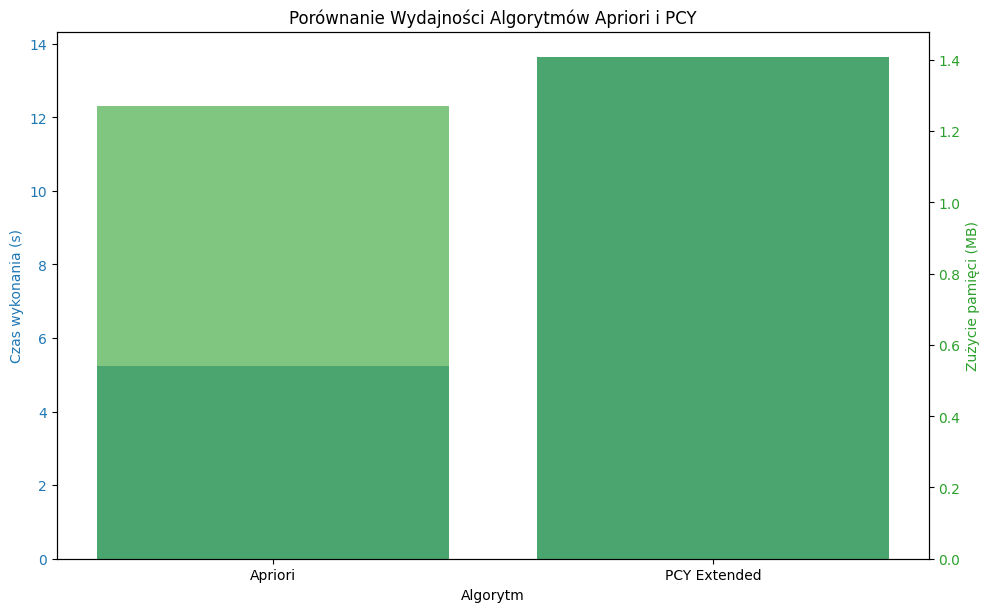

In [ ]:
import matplotlib.pyplot as plt

# Przygotowanie danych do wykresu
algorithms = data_comparison['Algorytm']
times = data_comparison['Czas wykonania (s)']
memory = data_comparison['Zużycie pamięci (MB)']

fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel('Algorytm')
ax1.set_ylabel('Czas wykonania (s)', color=color)
ax1.bar(algorithms, times, color=color, alpha=0.6, label='Czas wykonania')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel('Zużycie pamięci (MB)', color=color)
ax2.bar(algorithms, memory, color=color, alpha=0.6, label='Zużycie pamięci')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Porównanie Wydajności Algorytmów Apriori i PCY')
plt.show()


### 7. Interpretacja Wyników

Z przeprowadzonych eksperymentów wynika, że algorytm PCY jest wydajniejszy niż Apriori zarówno pod względem czasu wykonania, jak i zużycia pamięci. Wynika to z zastosowania tablicy haszującej i bitmapy, które zmniejszają liczbę kandydatów do zliczenia.

**Korzyści algorytmu PCY:**
- **Redukcja liczby kandydatów:** Dzięki tablicy haszującej i bitmapie, PCY skutecznie eliminuje niektóre nieczęste pary, co zmniejsza liczbę zliczeń.
- **Optymalizacja pamięci:** Mniejsza liczba kandydatów przekłada się na mniejsze zużycie pamięci w porównaniu do Apriori, który może generować dużą liczbę kandydatów.

**Sytuacje, w których PCY jest najbardziej korzystny:**
- **Duże zbiory danych:** Przy bardzo dużych zbiorach transakcji, gdzie liczba potencjalnych par jest ogromna, PCY znacząco redukuje liczbę kandydatów.
- **Nisza liczba częstych par:** Jeśli wiele par jest nieczęstych, PCY skutecznie je eliminuje w pierwszej iteracji.

### 8. Ograniczenia Algorytmu PCY

**Kolizje w funkcji haszującej:**
- **Opis problemu:** Funkcja haszująca może prowadzić do kolizji, gdzie różne pary są umieszczane w tym samym koszyku.
- **Wpływ na wyniki:** Kolizje mogą skutkować ustawieniem bitu w bitmapie dla koszyka, który zawiera zarówno częste, jak i nieczęste pary, co z kolei może prowadzić do fałszywych kandydatów.

**Sposoby radzenia sobie z kolizjami:**
- **Poprawa funkcji haszującej:** Użycie lepszej funkcji haszującej może zmniejszyć liczbę kolizji.
- **Zwiększenie liczby koszyków:** Większa liczba koszyków zmniejsza prawdopodobieństwo kolizji.

**Potencjalne Optymalizacje:**
- **Liniowe przeszukiwanie dla większych k:** Zamiast przeprowadzać pełną hash distinguishację dla k > 2, można zastosować bardziej zaawansowane metody filtracji.
- **Dynamiczna alokacja pamięci:** Zamiast statycznej tablicy haszującej, można użyć dynamicznych struktur danych, które lepiej dostosowują się do rozmiaru danych.

**Alternatywne Podejścia:**
- **Algorytm SON (Savasere, Omiecinski, and Navathe):** Efektywny w środowiskach rozproszonych.
- **Algorytm FP-Growth:** Używa drzewa FP do przechowywania zbiorów częstych bez generowania kandydatów.

### 9. Podsumowanie

Algorytm PCY okazuje się być efektywniejszy niż klasyczny algorytm Apriori, szczególnie w dużych zbiorach danych, dzięki zastosowaniu tablicy haszującej i bitmapy. Jednakże, należy być świadomym jego ograniczeń, takich jak kolizje w funkcji haszującej, które mogą wpływać na dokładność wyników. Dalsze optymalizacje i alternatywne podejścia mogą dodatkowo zwiększyć wydajność i skalowalność algorytmów do wydobywania częstych zbiorów elementów.


    Jaka jest główna idea algorytmu PCY?
    Po co wykorzystuje się hashe i kubełki?
    Jak wygląda algorytm PCY?
    Ile pamięci potrzebuje algorytm PCY?
    Co daje wariant wielostopniowy?
    Po co stosuje się MultiHash?
